# In Previous update we did trasfer learning using UNET which is trained on imagenet Dataset. In mininetwork we used same UNET architecture(ecoder, decoder) from scrath to create a mininetwork.

In [ ]:
!nvidia-smi

Tue May  9 16:44:50 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   51C    P8    10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import numpy as np
import pandas as pd
import os, glob
from torch.utils.data import Dataset
import torch
from PIL import Image
import matplotlib.pyplot as plt
from albumentations.pytorch import ToTensorV2
import albumentations as A

In [ ]:
import torch.nn as nn
from torch.optim import Adam
from tqdm import tqdm

In [ ]:
IMAGE_DIR = "/content/drive/MyDrive/Unet/Dataset_AL/images"
MASKS_DIR = "/content/drive/MyDrive/Unet/Dataset_AL/annotations"

In [ ]:
IMAGE_PATHS = glob.glob(IMAGE_DIR + "/*")
MASKS_PATHS = glob.glob(MASKS_DIR + "/*")

IMAGE_PATHS.sort()
MASKS_PATHS.sort()


In [ ]:
IMAGE_PATHS[10], MASKS_PATHS[10]

('/content/drive/MyDrive/Unet/Dataset_AL/images/UNH_DL_100.jpg',
 '/content/drive/MyDrive/Unet/Dataset_AL/annotations/UNH_DL_100.png')

In [ ]:
df = pd.DataFrame({
    'image_path' : IMAGE_PATHS,
    'mask_path' : MASKS_PATHS
})

df.head()

image_path  \
0  /content/drive/MyDrive/Unet/Dataset_AL/images/...   
1  /content/drive/MyDrive/Unet/Dataset_AL/images/...   
2  /content/drive/MyDrive/Unet/Dataset_AL/images/...   
3  /content/drive/MyDrive/Unet/Dataset_AL/images/...   
4  /content/drive/MyDrive/Unet/Dataset_AL/images/...   

                                           mask_path  
0  /content/drive/MyDrive/Unet/Dataset_AL/annotat...  
1  /content/drive/MyDrive/Unet/Dataset_AL/annotat...  
2  /content/drive/MyDrive/Unet/Dataset_AL/annotat...  
3  /content/drive/MyDrive/Unet/Dataset_AL/annotat...  
4  /content/drive/MyDrive/Unet/Dataset_AL/annotat...

In [ ]:
df.shape

(130, 2)

## Dataset

In [ ]:
class UnetDataset(Dataset):
    def __init__(self,df, transform = None):

        self.df = df
        self.transforms = transform

        
    def __len__(self):
        return len(self.df)

    def __getitem__(self,idx):

        img = np.array(Image.open(self.df.iloc[idx]['image_path']))
        mask = np.array(Image.open(self.df.iloc[idx]['mask_path']))

        if self.transforms is not None:
            aug = self.transforms(image=img, mask=mask)
            img = aug['image']
            mask = aug['mask']
            # mask = torch.max(mask, dim=2)[0]
            mask = mask.long()

        return img, mask

## Image mean and std

In [ ]:
transforms_tmp = A.Compose([
    A.Resize(width=256, height=256),
    A.Normalize(mean = (0, 0, 0), std  = (1, 1, 1)),
    ToTensorV2(),
])

In [ ]:
d = UnetDataset(df, transform=transforms_tmp)
dataloader = torch.utils.data.DataLoader(d,
                                        batch_size=1,
                                        shuffle=True,
                                        num_workers=2)

In [ ]:
# placeholders
psum    = torch.tensor([0.0, 0.0, 0.0])
psum_sq = torch.tensor([0.0, 0.0, 0.0])

for i, (image, target) in enumerate(tqdm(dataloader)):
    
    psum    += image.sum(axis        = [0, 2, 3])
    psum_sq += (image ** 2).sum(axis = [0, 2, 3])


100%|██████████| 130/130 [00:16<00:00,  7.93it/s]


In [ ]:
####### FINAL CALCULATIONS

# pixel count
count = len(df) * 256 * 256

# mean and std
total_mean = psum / count
total_var  = (psum_sq / count) - (total_mean ** 2)
total_std  = torch.sqrt(total_var)

# output
print('mean: '  + str(total_mean))
print('std:  '  + str(total_std))

mean: tensor([0.4893, 0.4996, 0.4967])
std:  tensor([0.2438, 0.2386, 0.2563])


## Transforms

In [ ]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

# Define a list of augmentations to apply
transforms_train = A.Compose([
    A.Resize(width=256, height=256),
    A.HorizontalFlip(p=0.5),
    A.Rotate(limit=30, p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    A.Blur(p=0.1),
    A.Normalize(total_mean, total_std),
    ToTensorV2(),

])

transforms_val = A.Compose([
    A.Resize(width=256, height=256),
    A.Normalize(total_mean, total_std),
    ToTensorV2(),
])

## Plot

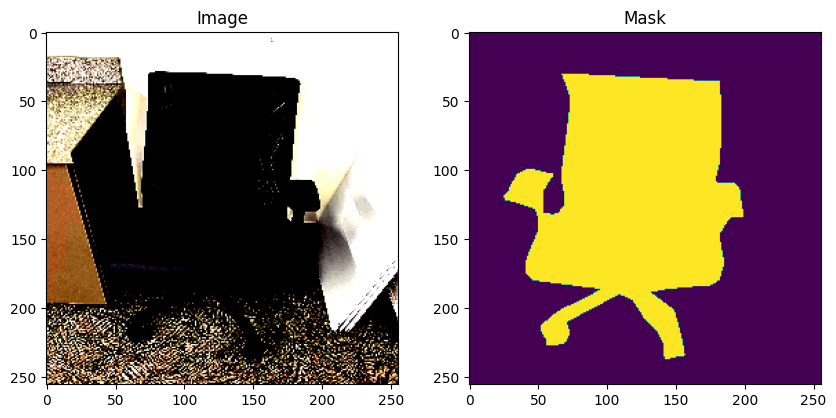

In [ ]:
d = UnetDataset(df, transform=transforms_train)
image, mask = d.__getitem__(15)

# Convert the tensors back to NumPy arrays
image = image.permute(1, 2, 0).numpy()
mask = mask.numpy()

# Plot the image and mask side-by-side
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

ax[0].imshow(image)
ax[0].set_title("Image")

ax[1].imshow(mask)
ax[1].set_title("Mask")

plt.show()

## Train Valid Test split

In [ ]:
# lengths of training, validation, and test sets
data_length = len(df)
print(data_length)
train_length = int(0.8 * data_length)
validation_length = int(0.1 * data_length)
test_length = data_length - train_length - validation_length

130


In [ ]:
train_length, validation_length, test_length

(104, 13, 13)

In [ ]:
from sklearn.model_selection import train_test_split

train_df, valid_df = train_test_split(df, test_size=0.1, shuffle=True)
train_df, test_df = train_test_split(train_df, test_size=0.11, shuffle=True)

train_df.shape, valid_df.shape, test_df.shape

((104, 2), (13, 2), (13, 2))

## Model

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
class encoding_block(nn.Module):
    def __init__(self,in_channels, out_channels):
        super(encoding_block,self).__init__()
        model = []
        model.append(nn.Conv2d(in_channels, out_channels, 3, 1, 1, bias=False))
        model.append(nn.BatchNorm2d(out_channels))
        model.append(nn.ReLU(inplace=True))
        model.append(nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias=False))
        model.append(nn.BatchNorm2d(out_channels))
        model.append(nn.ReLU(inplace=True))
        self.conv = nn.Sequential(*model)
    def forward(self, x):
        return self.conv(x) 

In [ ]:
class UNet(nn.Module):
    def __init__(self,out_channels=2, features=[64, 128, 256, 512]):
        super(UNet, self).__init__()
        self.pool = nn.MaxPool2d(kernel_size=(2,2),stride=(2,2))
        self.conv1 = encoding_block(3,features[0])
        self.conv2 = encoding_block(features[0],features[1])
        self.conv3 = encoding_block(features[1],features[2])
        self.conv4 = encoding_block(features[2],features[3])
        self.conv5 = encoding_block(features[3]*2,features[3])
        self.conv6 = encoding_block(features[3],features[2])
        self.conv7 = encoding_block(features[2],features[1])
        self.conv8 = encoding_block(features[1],features[0])        
        self.tconv1 = nn.ConvTranspose2d(features[-1]*2, features[-1], kernel_size=2, stride=2)
        self.tconv2 = nn.ConvTranspose2d(features[-1], features[-2], kernel_size=2, stride=2)
        self.tconv3 = nn.ConvTranspose2d(features[-2], features[-3], kernel_size=2, stride=2)
        self.tconv4 = nn.ConvTranspose2d(features[-3], features[-4], kernel_size=2, stride=2)        
        self.bottleneck = encoding_block(features[3],features[3]*2)
        self.final_layer = nn.Conv2d(features[0],out_channels,kernel_size=1)

    # Initialize the weights and biases
        self._initialize_weights()


    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def forward(self,x):
        skip_connections = []
        x = self.conv1(x)
        skip_connections.append(x)
        x = self.pool(x)
        x = self.conv2(x)
        skip_connections.append(x)
        x = self.pool(x)
        x = self.conv3(x)
        skip_connections.append(x)
        x = self.pool(x)
        x = self.conv4(x)
        skip_connections.append(x)
        x = self.pool(x)
        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1]
        x = self.tconv1(x)
        x = torch.cat((skip_connections[0], x), dim=1)
        x = self.conv5(x)
        x = self.tconv2(x)
        x = torch.cat((skip_connections[1], x), dim=1)
        x = self.conv6(x)
        x = self.tconv3(x)
        x = torch.cat((skip_connections[2], x), dim=1)
        x = self.conv7(x)        
        x = self.tconv4(x)
        x = torch.cat((skip_connections[3], x), dim=1)
        x = self.conv8(x)
        x = self.final_layer(x)
        return x

In [ ]:
model = UNet(out_channels=5+1)

input = torch.rand(1, 3, 256, 256)
output = model(input)

In [ ]:
input.shape, output.shape

(torch.Size([1, 3, 256, 256]), torch.Size([1, 6, 256, 256]))

## Train Valid Test Functions

In [ ]:
def train_epoch(model, optimizer, criterion, data_loader, device):
    # Set the model to training mode
    model.train()

    # Initialize variables to keep track of loss and accuracy
    running_loss = 0
    num_correct = 0
    num_pixels = 0
    dice_score = 0

    # Loop over the data loader
    for batch_idx, (inputs, targets) in enumerate(tqdm(data_loader)):
        # Move the inputs and targets to the device
        inputs, targets = inputs.to(device), targets.to(device)

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, targets)

        # Backward pass
        loss.backward()
        optimizer.step()

        # Update the running loss and accuracy
        running_loss += loss.item() * inputs.size(0)

        softmax = nn.Softmax(dim=1)
        preds = torch.argmax(softmax(outputs),axis=1)
        num_correct += (preds == targets).sum()
        num_pixels += torch.numel(preds)
        dice_score += (2 * (preds * targets).sum()) / ((preds + targets).sum() + 1e-8)

    # Calculate the average loss and accuracy for the epoch
    avg_loss = running_loss / len(data_loader.dataset)
    dice_score = dice_score / len(data_loader.dataset)

    print("Train loss : ", avg_loss)
    print("Train dice score : ", dice_score.item())

    return avg_loss, dice_score.item()

In [ ]:
def valid_epoch(model, optimizer, criterion, data_loader, device):
    # Set the model to training mode
    model.eval()

    # Initialize variables to keep track of loss and accuracy
    running_loss = 0
    num_correct = 0
    num_pixels = 0
    dice_score = 0


    # Disable gradient calculation to speed up inference
    with torch.no_grad():
        # Loop over the data loader
        for batch_idx, (inputs, targets) in enumerate(tqdm(data_loader)):
            # Move the inputs and targets to the device
            inputs, targets = inputs.to(device), targets.to(device)

            # Zero the gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, targets)

    
            # Update the running loss and accuracy
            running_loss += loss.item() * inputs.size(0)

            softmax = nn.Softmax(dim=1)
            preds = torch.argmax(softmax(outputs),axis=1)
            num_correct += (preds == targets).sum()
            num_pixels += torch.numel(preds)
            dice_score += (2 * (preds * targets).sum()) / ((preds + targets).sum() + 1e-8)

    # Calculate the average loss and accuracy for the epoch
    avg_loss = running_loss / len(data_loader.dataset)
    dice_score = dice_score / len(data_loader.dataset)

    print("Valid loss : ", avg_loss)
    print("Valid dice score : ", dice_score.item())

    return avg_loss, dice_score.item()

## Data Loaders

In [ ]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
LEARNING_RATE = 1e-3
WEIGHT_DECAY = 5e-4
BATCH_SIZE = 4
NUM_WORKERS = 4
CHECKPOINT_FILE = "Best.pth.tar"
PIN_MEMORY = True
SAVE_MODEL = True
LOAD_MODEL = False

In [ ]:
from torch.utils.data import Dataset, DataLoader

In [ ]:
train_dataset = UnetDataset(train_df, transform=transforms_train)
train_loader = DataLoader(dataset=train_dataset,
                              batch_size=BATCH_SIZE,
                              shuffle=True,
                              num_workers=2,
                              pin_memory=PIN_MEMORY)

valid_dataset = UnetDataset(valid_df, transform=transforms_val)
valid_loader = DataLoader(dataset=valid_dataset,
                              batch_size=BATCH_SIZE,
                              shuffle=False,
                              pin_memory=PIN_MEMORY)

test_dataset = UnetDataset(test_df, transform=transforms_val)
test_loader = DataLoader(dataset=test_dataset,
                              batch_size=BATCH_SIZE,
                              shuffle=False,
                              pin_memory=PIN_MEMORY)

In [ ]:
def save_checkpoint(state, filename="model.pth.tar"):
    print("=> Saving checkpoint")
    torch.save(state, filename)

In [ ]:
def load_checkpoint(checkpoint, model):
    print("=> Loading checkpoint")
    model.load_state_dict(checkpoint["state_dict"])

## Model and optimizer and loss

In [ ]:
# model 

model = UNet(out_channels=5+1)
model.to(DEVICE)

optimizer = torch.optim.AdamW(params=model.parameters(),
                                  lr=LEARNING_RATE,
                                  weight_decay=WEIGHT_DECAY)

criterion = nn.CrossEntropyLoss()

## Overfiting model on training data

In [ ]:
train_dataset1 = UnetDataset(train_df.sample(1), transform=transforms_train)
train_loader1 = DataLoader(dataset=train_dataset1,
                              batch_size=BATCH_SIZE,
                              shuffle=True,
                              num_workers=2,
                              pin_memory=PIN_MEMORY)



for epoch in range(10):
    print("Epoch = ", epoch)

    train_loss, train_score  = train_epoch(
        model, 
        optimizer=optimizer, 
        criterion=criterion,
        data_loader=train_loader1,
        device=DEVICE
    )

Epoch =  0


100%|██████████| 1/1 [00:00<00:00,  1.74it/s]


Train loss :  1.6151604652404785
Train dice score :  0.47445040941238403
Epoch =  1


100%|██████████| 1/1 [00:00<00:00,  1.82it/s]


Train loss :  1.4422485828399658
Train dice score :  0.6047606468200684
Epoch =  2


100%|██████████| 1/1 [00:00<00:00,  1.82it/s]


Train loss :  1.1793590784072876
Train dice score :  0.8311318755149841
Epoch =  3


100%|██████████| 1/1 [00:00<00:00,  1.85it/s]


Train loss :  1.0406230688095093
Train dice score :  0.8936702013015747
Epoch =  4


100%|██████████| 1/1 [00:00<00:00,  1.80it/s]


Train loss :  0.9175289869308472
Train dice score :  0.8488644361495972
Epoch =  5


100%|██████████| 1/1 [00:00<00:00,  1.85it/s]


Train loss :  0.8025119304656982
Train dice score :  0.8418070077896118
Epoch =  6


100%|██████████| 1/1 [00:00<00:00,  1.85it/s]


Train loss :  0.7840336561203003
Train dice score :  0.8662620782852173
Epoch =  7


100%|██████████| 1/1 [00:00<00:00,  1.88it/s]


Train loss :  0.751652717590332
Train dice score :  0.899687647819519
Epoch =  8


100%|██████████| 1/1 [00:00<00:00,  1.89it/s]


Train loss :  0.7180434465408325
Train dice score :  0.9020321369171143
Epoch =  9


100%|██████████| 1/1 [00:00<00:00,  1.88it/s]

Train loss :  0.6745339632034302
Train dice score :  0.8812836408615112


  0%|          | 0/1 [00:00<?, ?it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


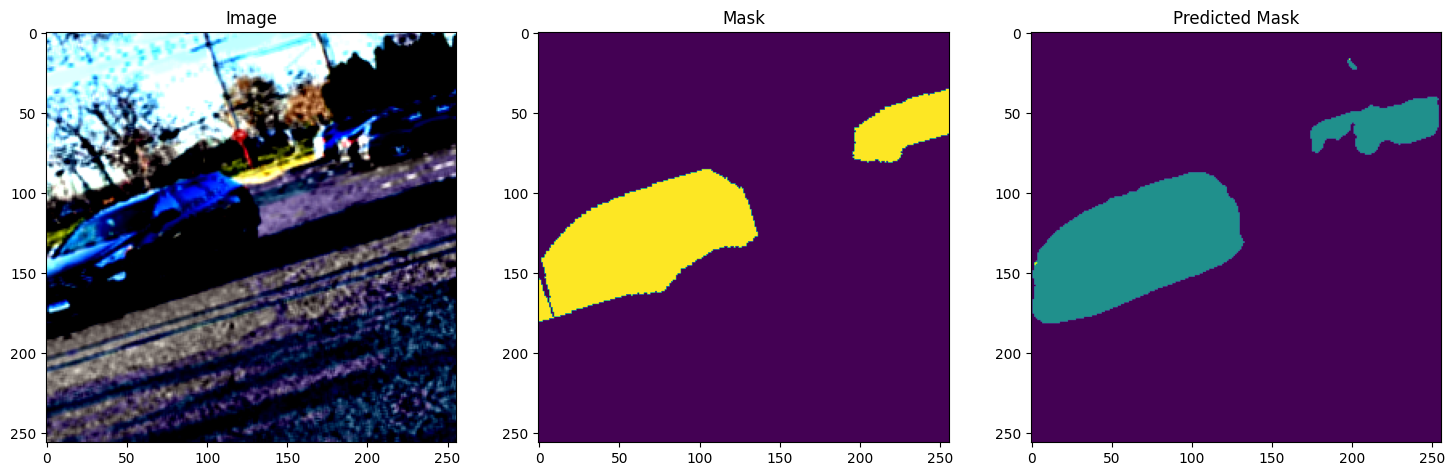

100%|██████████| 1/1 [00:01<00:00,  1.40s/it]


In [ ]:
softmax = nn.Softmax(dim=1)
# Disable gradient calculation to speed up inference
with torch.no_grad():
    # Loop over the data loader
    for batch_idx, (inputs, targets) in enumerate(tqdm(train_loader1)):
        # Move the inputs and targets to the device
        inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)

        # Forward pass
        outputs = model(inputs)
        outputs = torch.argmax(softmax(outputs),axis=1)

        for i in range(inputs.shape[0]):

            image = inputs[i].to('cpu')
            mask = targets[i].to('cpu')
            pred_mask = outputs[i].to('cpu')

            fig , ax =  plt.subplots(1, 3, figsize=(18, 18))
            softmax = nn.Softmax(dim=1)

            image = image.permute(1, 2, 0).numpy()
            mask = mask.numpy()
            pred_mask = pred_mask.numpy()

            ax[0].imshow(image)
            ax[0].set_title("Image")

            ax[1].imshow(mask)
            ax[1].set_title("Mask")

            ax[2].imshow(pred_mask)
            ax[2].set_title("Predicted Mask")

            plt.show()

        # break



## Hyperparameter tunning

 learning rate, momentum, and weight decay

In [ ]:
best_score = -np.inf

best_lr = None
best_weight_decay = None

for lr in [ 0.001, 0.01, 0.1]:
    for weight_decay in [0.0001, 0.001, 0.01]:

        model = UNet(out_channels=5+1)
        model.to(DEVICE)

        optimizer = torch.optim.AdamW(params=model.parameters(),
                                        lr=lr,
                                        weight_decay=weight_decay)

        criterion = nn.CrossEntropyLoss()



        train_loss, train_score  = train_epoch(
            model, 
            optimizer=optimizer, 
            criterion=criterion,
            data_loader=train_loader,
            device=DEVICE
        )

        valid_loss, valid_score  = valid_epoch(
            model, 
            optimizer=optimizer, 
            criterion=criterion,
            data_loader=valid_loader,
            device=DEVICE
        )

        if valid_score > best_score:
            best_score = valid_score

            best_lr = lr
            best_weight_decay = weight_decay



best_lr, best_weight_decay

100%|██████████| 26/26 [00:15<00:00,  1.72it/s]


Train loss :  1.2057688465485206
Train dice score :  0.1017453745007515


100%|██████████| 4/4 [00:03<00:00,  1.32it/s]


Valid loss :  3.228561364687406
Valid dice score :  0.1436549574136734


100%|██████████| 26/26 [00:15<00:00,  1.72it/s]


Train loss :  1.3119862492267902
Train dice score :  0.0923336073756218


100%|██████████| 4/4 [00:03<00:00,  1.30it/s]


Valid loss :  5.940927844781142
Valid dice score :  0.16841505467891693


100%|██████████| 26/26 [00:14<00:00,  1.79it/s]


Train loss :  1.229852781845973
Train dice score :  0.12860193848609924


100%|██████████| 4/4 [00:03<00:00,  1.33it/s]


Valid loss :  1.0678082842093248
Valid dice score :  0.1276569962501526


100%|██████████| 26/26 [00:14<00:00,  1.83it/s]


Train loss :  0.8607734304208022
Train dice score :  0.02353499084711075


100%|██████████| 4/4 [00:03<00:00,  1.31it/s]


Valid loss :  43.77381962308517
Valid dice score :  0.0004553273902274668


100%|██████████| 26/26 [00:14<00:00,  1.83it/s]


Train loss :  0.8768505454063416
Train dice score :  0.02549426071345806


100%|██████████| 4/4 [00:03<00:00,  1.30it/s]


Valid loss :  6.183049529790878
Valid dice score :  0.0


100%|██████████| 26/26 [00:14<00:00,  1.80it/s]


Train loss :  0.8849088240128297
Train dice score :  0.022647453472018242


100%|██████████| 4/4 [00:03<00:00,  1.31it/s]


Valid loss :  1.0279537324721997
Valid dice score :  0.011607266962528229


100%|██████████| 26/26 [00:14<00:00,  1.82it/s]


Train loss :  0.8407229781150818
Train dice score :  0.011387759819626808


100%|██████████| 4/4 [00:03<00:00,  1.27it/s]


Valid loss :  255.50482940673828
Valid dice score :  0.0


100%|██████████| 26/26 [00:14<00:00,  1.81it/s]


Train loss :  0.7958291104206672
Train dice score :  0.0036396444775164127


100%|██████████| 4/4 [00:03<00:00,  1.33it/s]


Valid loss :  1991.4961327772874
Valid dice score :  0.0


100%|██████████| 26/26 [00:14<00:00,  1.79it/s]


Train loss :  0.8863115333593808
Train dice score :  0.00577913923189044


100%|██████████| 4/4 [00:03<00:00,  1.32it/s]

Valid loss :  42.11325320830712
Valid dice score :  0.12204891443252563


(0.001, 0.001)

In [ ]:
best_lr, best_weight_decay

(0.001, 0.001)

## Training

In [ ]:
LEARNING_RATE = best_lr #1e-3
WEIGHT_DECAY = best_weight_decay #5e-4

In [ ]:
LEARNING_RATE = 1e-3
WEIGHT_DECAY = 5e-4

In [ ]:
model = UNet(out_channels=5+1)
model.to(DEVICE)

optimizer = torch.optim.AdamW(params=model.parameters(),
                                lr=LEARNING_RATE,
                                weight_decay=WEIGHT_DECAY)

criterion = nn.CrossEntropyLoss()


In [ ]:
NUM_EPOCHS = 30

In [ ]:
best_score = -np.inf

train_loss_list = []
train_score_list = []

valid_loss_list = []
valid_score_list = []

for epoch in range(NUM_EPOCHS):

    print("Epoch = ", epoch)

    train_loss, train_score  = train_epoch(
        model, 
        optimizer=optimizer, 
        criterion=criterion,
        data_loader=train_loader,
        device=DEVICE
    )

    valid_loss, valid_score  = valid_epoch(
        model, 
        optimizer=optimizer, 
        criterion=criterion,
        data_loader=valid_loader,
        device=DEVICE
    )

    train_loss_list.append(train_loss)
    train_score_list.append(train_score)

    valid_loss_list.append(valid_loss)
    valid_score_list.append(valid_score)

    if valid_score > best_score:
      best_score = valid_score
      if SAVE_MODEL:
            print("Model improved, saving...")
            checkpoint = {
                "state_dict": model.state_dict(),
                "optimizer": optimizer.state_dict(),
            }
            save_checkpoint(checkpoint, filename=f"/content/drive/MyDrive/Unet/MINI_Unet_Best.pth.tar")
    print('\n')



Epoch =  0


100%|██████████| 26/26 [00:14<00:00,  1.76it/s]


Train loss :  1.2476573013342345
Train dice score :  0.08314365893602371


100%|██████████| 4/4 [00:03<00:00,  1.27it/s]


Valid loss :  1.167629361152649
Valid dice score :  0.034658610820770264
Model improved, saving...
=> Saving checkpoint


Epoch =  1


100%|██████████| 26/26 [00:14<00:00,  1.80it/s]


Train loss :  0.8419976830482483
Train dice score :  0.039488714188337326


100%|██████████| 4/4 [00:03<00:00,  1.26it/s]


Valid loss :  0.9681942600470322
Valid dice score :  0.10438269376754761
Model improved, saving...
=> Saving checkpoint


Epoch =  2


100%|██████████| 26/26 [00:15<00:00,  1.71it/s]


Train loss :  0.7296106746563544
Train dice score :  0.03503970056772232


100%|██████████| 4/4 [00:03<00:00,  1.21it/s]


Valid loss :  0.8928506511908311
Valid dice score :  0.02458646148443222


Epoch =  3


100%|██████████| 26/26 [00:14<00:00,  1.78it/s]


Train loss :  0.6906019552395894
Train dice score :  0.027427153661847115


100%|██████████| 4/4 [00:03<00:00,  1.32it/s]


Valid loss :  0.8520097549145038
Valid dice score :  0.017835283651947975


Epoch =  4


100%|██████████| 26/26 [00:14<00:00,  1.82it/s]


Train loss :  0.6704001931043772
Train dice score :  0.03240266442298889


100%|██████████| 4/4 [00:03<00:00,  1.32it/s]


Valid loss :  0.8206080496311188
Valid dice score :  0.008662436157464981


Epoch =  5


100%|██████████| 26/26 [00:14<00:00,  1.82it/s]


Train loss :  0.6554523809598043
Train dice score :  0.015467824414372444


100%|██████████| 4/4 [00:03<00:00,  1.30it/s]


Valid loss :  0.8272094749487363
Valid dice score :  0.004202330484986305


Epoch =  6


100%|██████████| 26/26 [00:14<00:00,  1.78it/s]


Train loss :  0.6437448389255084
Train dice score :  0.03625857084989548


100%|██████████| 4/4 [00:03<00:00,  1.31it/s]


Valid loss :  0.7809476004197047
Valid dice score :  0.01859412156045437


Epoch =  7


100%|██████████| 26/26 [00:14<00:00,  1.75it/s]


Train loss :  0.6243345531133505
Train dice score :  0.049412090331315994


100%|██████████| 4/4 [00:03<00:00,  1.32it/s]


Valid loss :  0.8119312799893893
Valid dice score :  0.07507951557636261


Epoch =  8


100%|██████████| 26/26 [00:14<00:00,  1.77it/s]


Train loss :  0.6345491099816102
Train dice score :  0.041943199932575226


100%|██████████| 4/4 [00:03<00:00,  1.30it/s]


Valid loss :  0.7943372909839337
Valid dice score :  0.009358283132314682


Epoch =  9


100%|██████████| 26/26 [00:14<00:00,  1.80it/s]


Train loss :  0.6058349357201502
Train dice score :  0.05595178157091141


100%|██████████| 4/4 [00:03<00:00,  1.32it/s]


Valid loss :  0.9266647776732078
Valid dice score :  0.011807403527200222


Epoch =  10


100%|██████████| 26/26 [00:14<00:00,  1.86it/s]


Train loss :  0.6186931660542121
Train dice score :  0.06704144924879074


100%|██████████| 4/4 [00:03<00:00,  1.32it/s]


Valid loss :  0.8606838354697595
Valid dice score :  0.16748584806919098
Model improved, saving...
=> Saving checkpoint


Epoch =  11


100%|██████████| 26/26 [00:14<00:00,  1.82it/s]


Train loss :  0.5735325893530479
Train dice score :  0.10405883938074112


100%|██████████| 4/4 [00:03<00:00,  1.27it/s]


Valid loss :  0.6929159645850842
Valid dice score :  0.17510759830474854
Model improved, saving...
=> Saving checkpoint


Epoch =  12


100%|██████████| 26/26 [00:14<00:00,  1.81it/s]


Train loss :  0.5868111241322297
Train dice score :  0.10840272158384323


100%|██████████| 4/4 [00:03<00:00,  1.26it/s]


Valid loss :  0.8274962833294501
Valid dice score :  0.0213769618421793


Epoch =  13


100%|██████████| 26/26 [00:14<00:00,  1.78it/s]


Train loss :  0.5971231345946972
Train dice score :  0.06372759491205215


100%|██████████| 4/4 [00:03<00:00,  1.30it/s]


Valid loss :  0.7143219411373138
Valid dice score :  0.08615143597126007


Epoch =  14


100%|██████████| 26/26 [00:14<00:00,  1.77it/s]


Train loss :  0.5770060878533584
Train dice score :  0.10685397684574127


100%|██████████| 4/4 [00:03<00:00,  1.32it/s]


Valid loss :  0.6812461866782262
Valid dice score :  0.1448332518339157


Epoch =  15


100%|██████████| 26/26 [00:14<00:00,  1.85it/s]


Train loss :  0.5746508481410834
Train dice score :  0.10862919688224792


100%|██████████| 4/4 [00:03<00:00,  1.32it/s]


Valid loss :  0.7197995552649865
Valid dice score :  0.042692072689533234


Epoch =  16


100%|██████████| 26/26 [00:14<00:00,  1.80it/s]


Train loss :  0.5725673081783148
Train dice score :  0.09520527720451355


100%|██████████| 4/4 [00:03<00:00,  1.30it/s]


Valid loss :  0.757398050564986
Valid dice score :  0.11068412661552429


Epoch =  17


100%|██████████| 26/26 [00:15<00:00,  1.72it/s]


Train loss :  0.5729008809878275
Train dice score :  0.07995118200778961


100%|██████████| 4/4 [00:03<00:00,  1.30it/s]


Valid loss :  0.7452404040556687
Valid dice score :  0.0489567294716835


Epoch =  18


100%|██████████| 26/26 [00:14<00:00,  1.82it/s]


Train loss :  0.5641662730620458
Train dice score :  0.1156081035733223


100%|██████████| 4/4 [00:03<00:00,  1.32it/s]


Valid loss :  0.6806393414735794
Valid dice score :  0.17179416120052338


Epoch =  19


100%|██████████| 26/26 [00:14<00:00,  1.81it/s]


Train loss :  0.5555833142537338
Train dice score :  0.10239347815513611


100%|██████████| 4/4 [00:03<00:00,  1.26it/s]


Valid loss :  0.89966231240676
Valid dice score :  0.00428706593811512


Epoch =  20


100%|██████████| 26/26 [00:14<00:00,  1.82it/s]


Train loss :  0.5545899684612567
Train dice score :  0.10585465282201767


100%|██████████| 4/4 [00:03<00:00,  1.32it/s]


Valid loss :  0.691686905347384
Valid dice score :  0.103823222219944


Epoch =  21


100%|██████████| 26/26 [00:14<00:00,  1.76it/s]


Train loss :  0.5474112675740168
Train dice score :  0.11742405593395233


100%|██████████| 4/4 [00:03<00:00,  1.32it/s]


Valid loss :  0.671754682293305
Valid dice score :  0.1327986717224121


Epoch =  22


100%|██████████| 26/26 [00:14<00:00,  1.79it/s]


Train loss :  0.5477876078623992
Train dice score :  0.11006250232458115


100%|██████████| 4/4 [00:03<00:00,  1.29it/s]


Valid loss :  0.6668556928634644
Valid dice score :  0.11167226731777191


Epoch =  23


100%|██████████| 26/26 [00:14<00:00,  1.84it/s]


Train loss :  0.5439692930533335
Train dice score :  0.12616916000843048


100%|██████████| 4/4 [00:02<00:00,  1.34it/s]


Valid loss :  0.7802888051821635
Valid dice score :  0.009086656384170055


Epoch =  24


100%|██████████| 26/26 [00:14<00:00,  1.83it/s]


Train loss :  0.53352002455638
Train dice score :  0.1252955198287964


100%|██████████| 4/4 [00:02<00:00,  1.33it/s]


Valid loss :  0.6909337238623545
Valid dice score :  0.11758770048618317


Epoch =  25


100%|██████████| 26/26 [00:14<00:00,  1.82it/s]


Train loss :  0.5665271706306018
Train dice score :  0.11716224253177643


100%|██████████| 4/4 [00:03<00:00,  1.31it/s]


Valid loss :  0.7743223034418546
Valid dice score :  0.09266463667154312


Epoch =  26


100%|██████████| 26/26 [00:14<00:00,  1.80it/s]


Train loss :  0.5771467009415994
Train dice score :  0.10959058254957199


100%|██████████| 4/4 [00:03<00:00,  1.33it/s]


Valid loss :  0.7305118796917108
Valid dice score :  0.06824445724487305


Epoch =  27


100%|██████████| 26/26 [00:14<00:00,  1.84it/s]


Train loss :  0.5542146724004012
Train dice score :  0.10607340186834335


100%|██████████| 4/4 [00:03<00:00,  1.31it/s]


Valid loss :  0.6294951117955722
Valid dice score :  0.17580631375312805
Model improved, saving...
=> Saving checkpoint


Epoch =  28


100%|██████████| 26/26 [00:14<00:00,  1.76it/s]


Train loss :  0.548497314636524
Train dice score :  0.12256655097007751


100%|██████████| 4/4 [00:03<00:00,  1.25it/s]


Valid loss :  0.7040876728984026
Valid dice score :  0.05634910613298416


Epoch =  29


100%|██████████| 26/26 [00:14<00:00,  1.83it/s]


Train loss :  0.5379140629218175
Train dice score :  0.11529923230409622


100%|██████████| 4/4 [00:02<00:00,  1.33it/s]

Valid loss :  0.6927718325303152
Valid dice score :  0.05446914583444595




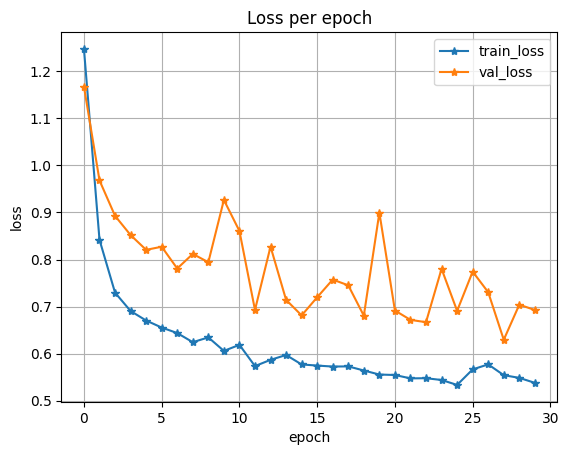

In [ ]:
plt.plot(train_loss_list, label='train_loss', marker='*')
plt.plot(valid_loss_list, label='val_loss', marker='*')
plt.title('Loss per epoch'); plt.ylabel('loss');
plt.xlabel('epoch')
plt.legend(), plt.grid()
plt.show()

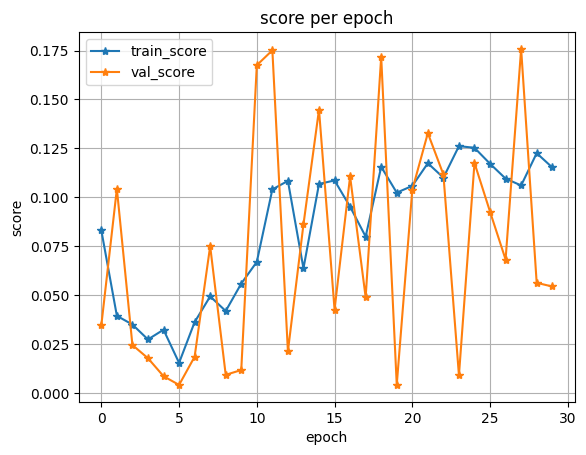

In [ ]:
plt.plot(train_score_list, label='train_score', marker='*')
plt.plot(valid_score_list, label='val_score', marker='*')
plt.title('score per epoch'); plt.ylabel('score');
plt.xlabel('epoch')
plt.legend(), plt.grid()
plt.show()

## Test

In [ ]:
best_check_point = torch.load("/content/drive/MyDrive/Unet/MINI_Unet_Best.pth.tar")

In [ ]:
model.load_state_dict(best_check_point['state_dict'])
model.eval()

UNet(
  (pool): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (conv1): encoding_block(
    (conv): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (conv2): encoding_block(
    (conv): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True,

In [ ]:
test_loss, test_score  = valid_epoch(
    model, 
    optimizer=optimizer, 
    criterion=criterion,
    data_loader=test_loader,
    device=DEVICE
)

100%|██████████| 4/4 [00:03<00:00,  1.32it/s]

Valid loss :  0.6054971676606399
Valid dice score :  0.20220284163951874


In [ ]:
print("Test Loss : ", test_loss)
print("Test Score : ", test_score)

Test Loss :  0.6054971676606399
Test Score :  0.20220284163951874


In [ ]:
softmax = nn.Softmax(dim=1)

  0%|          | 0/4 [00:00<?, ?it/s]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


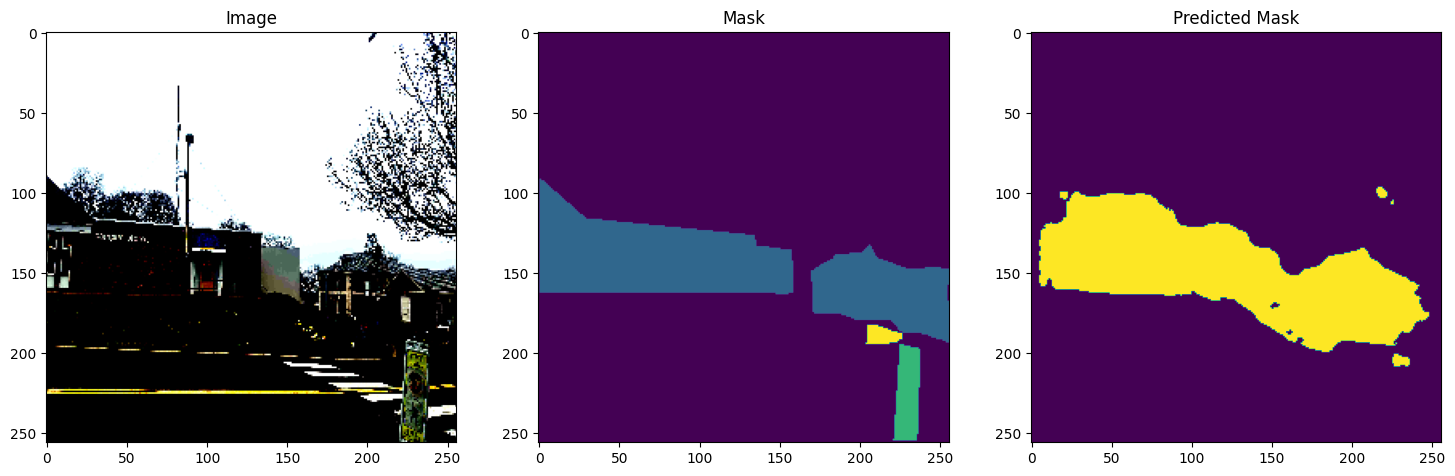

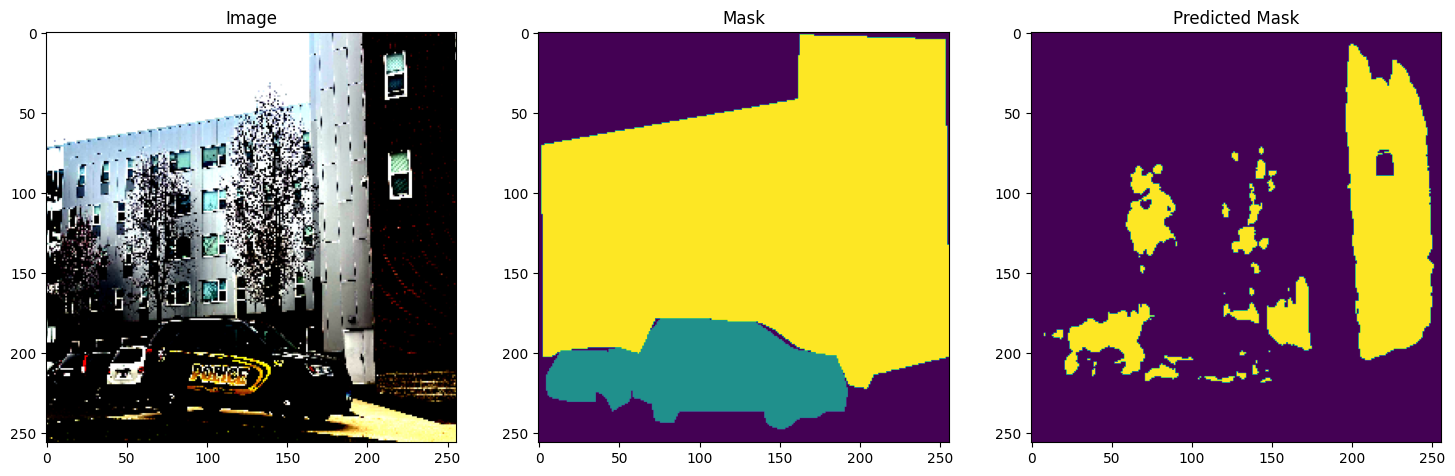

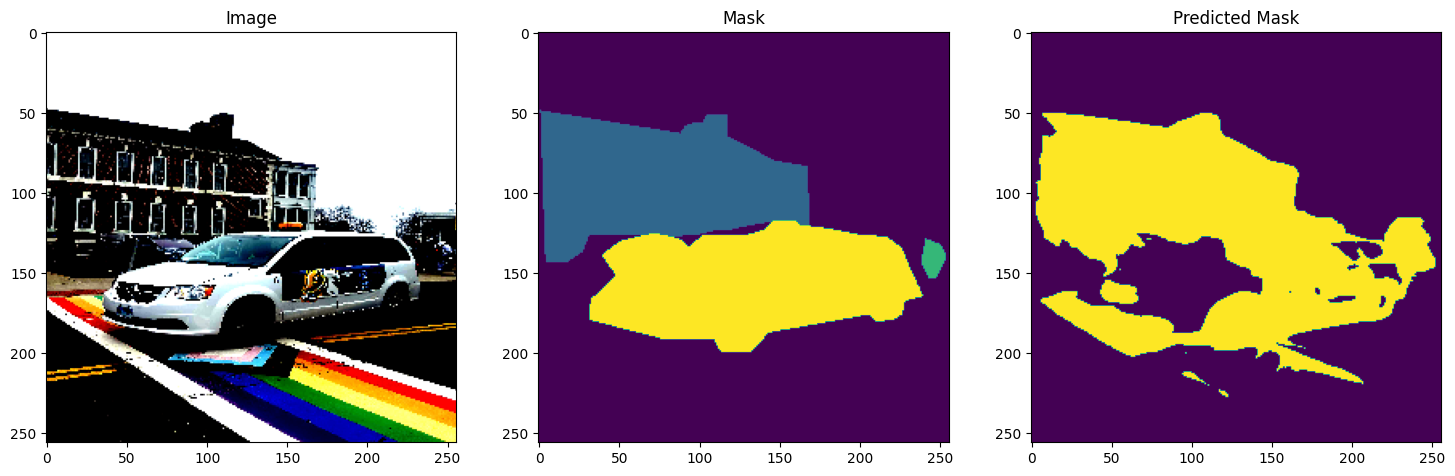

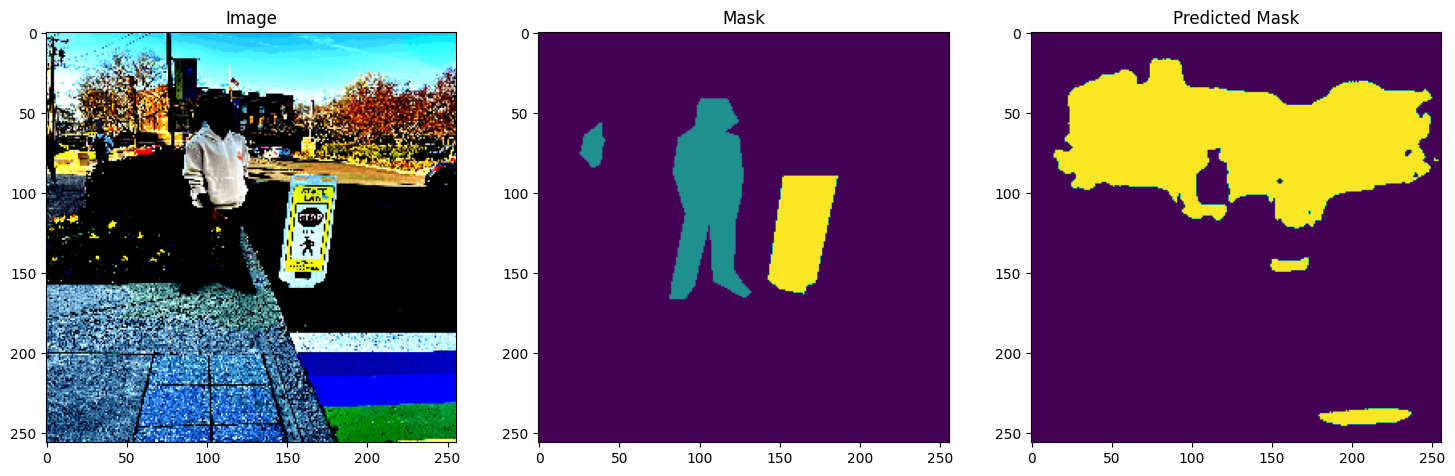

 25%|██▌       | 1/4 [00:03<00:10,  3.36s/it]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


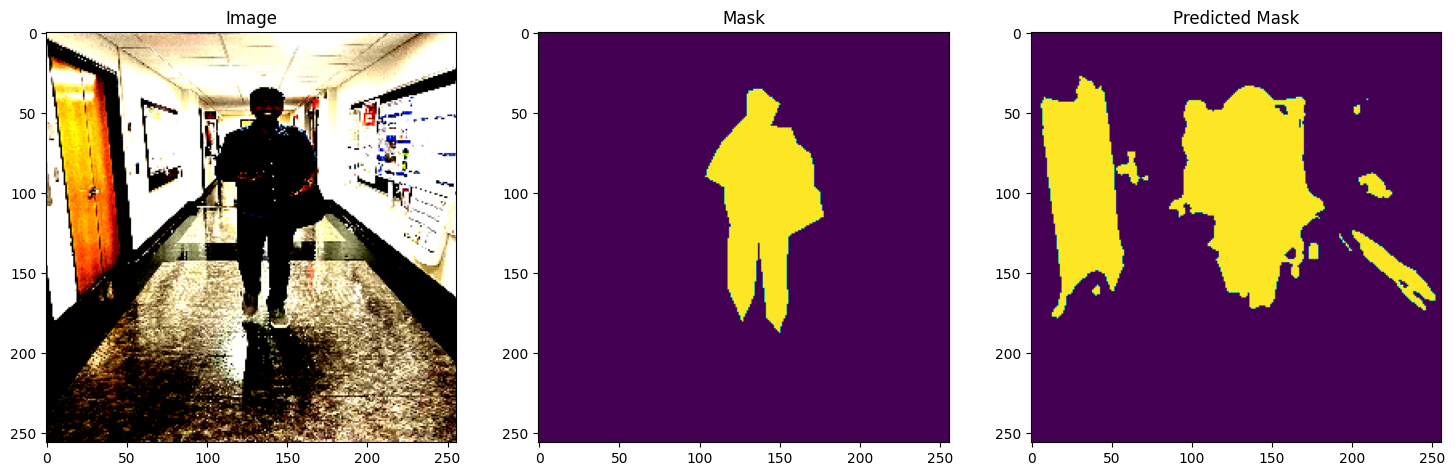

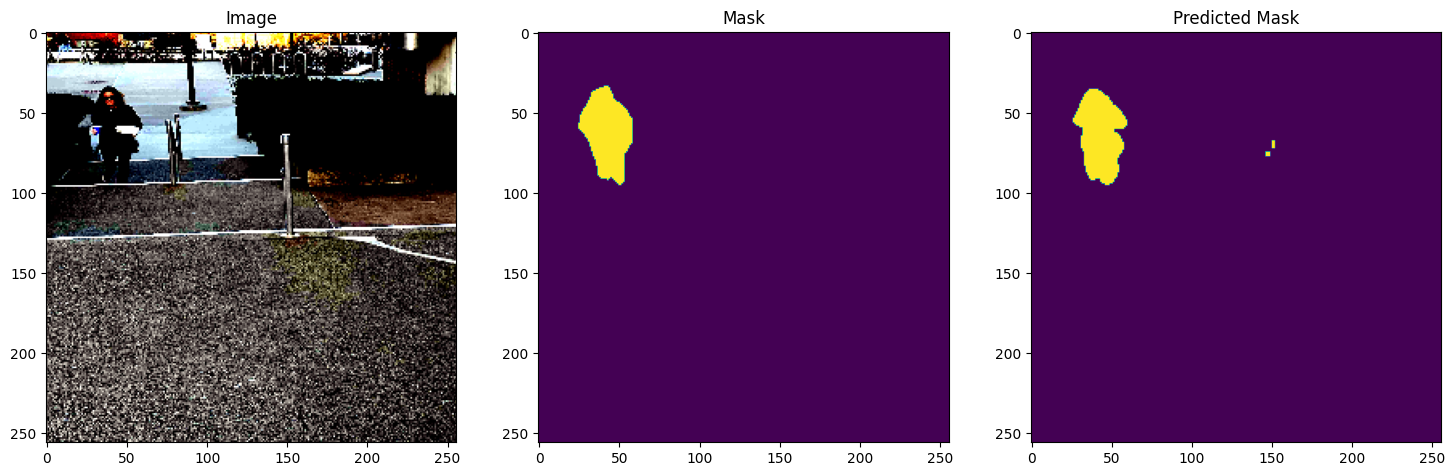

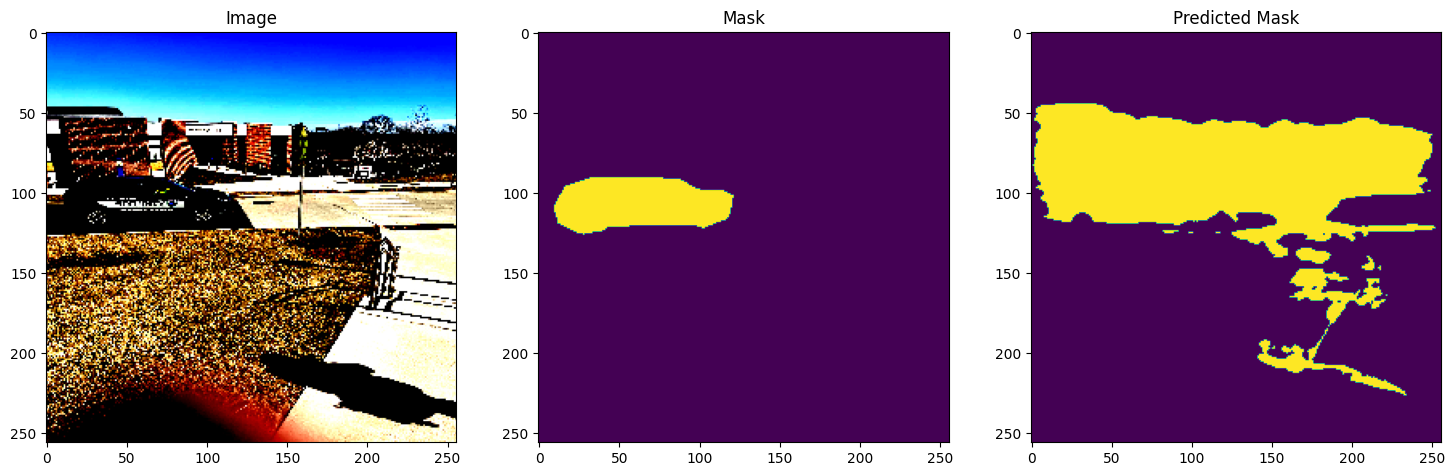

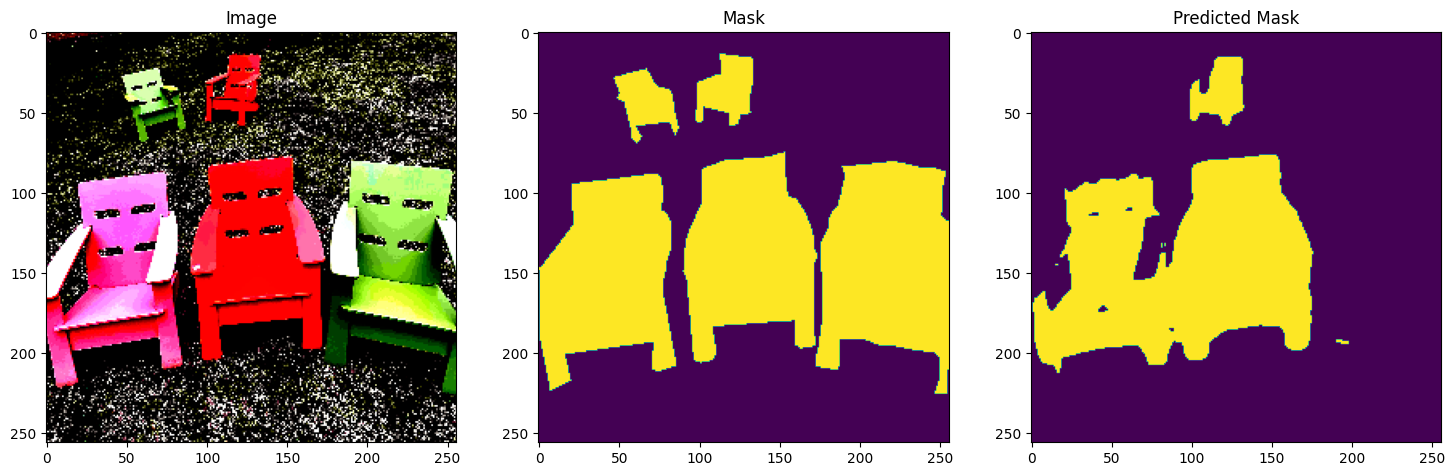

 50%|█████     | 2/4 [00:07<00:07,  3.58s/it]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


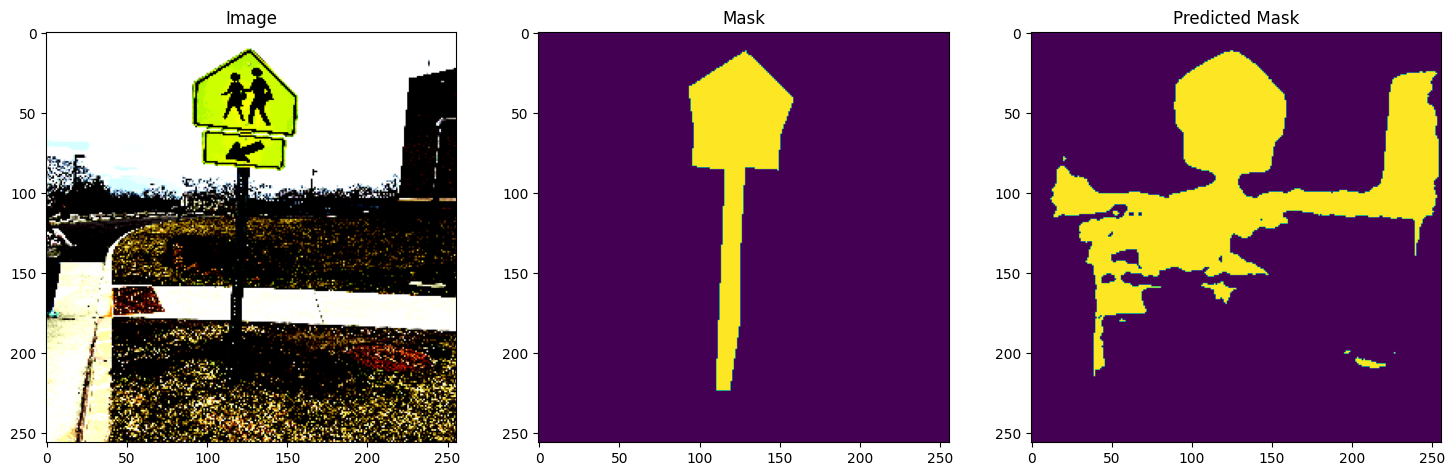

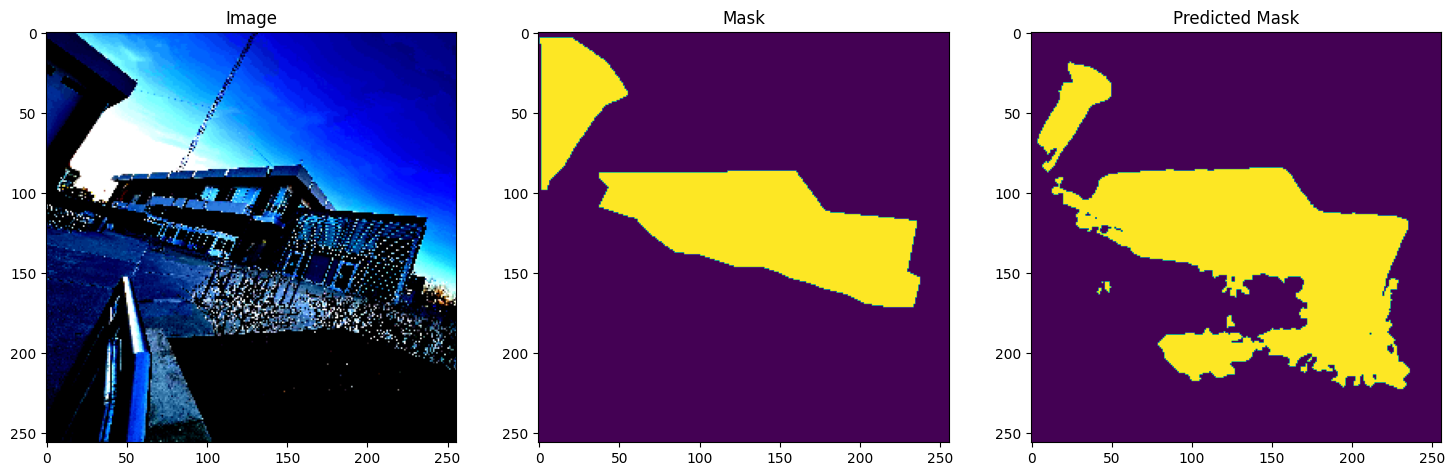

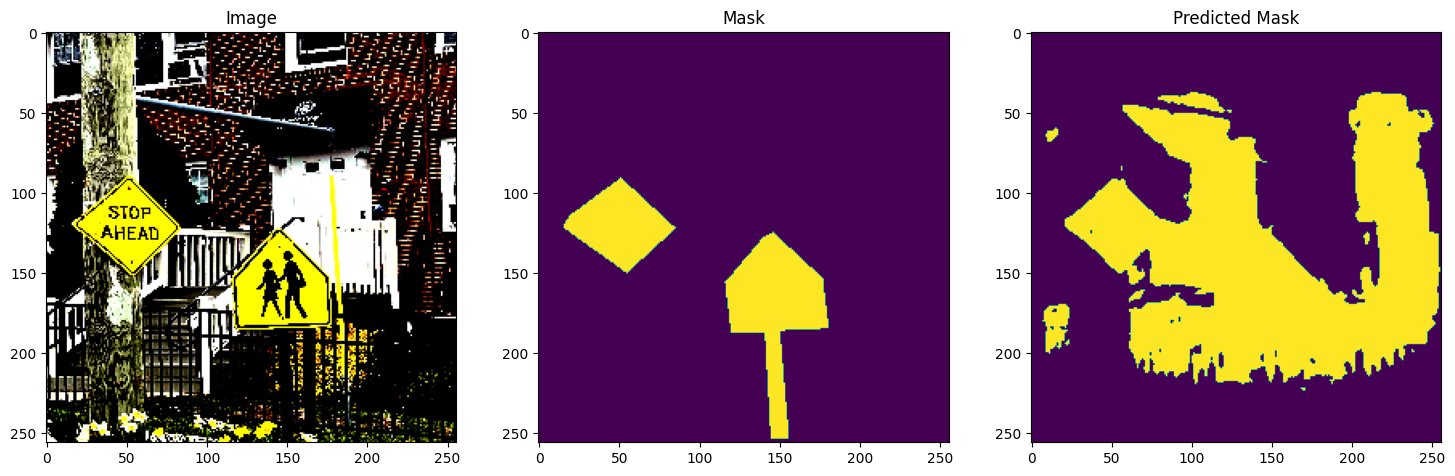

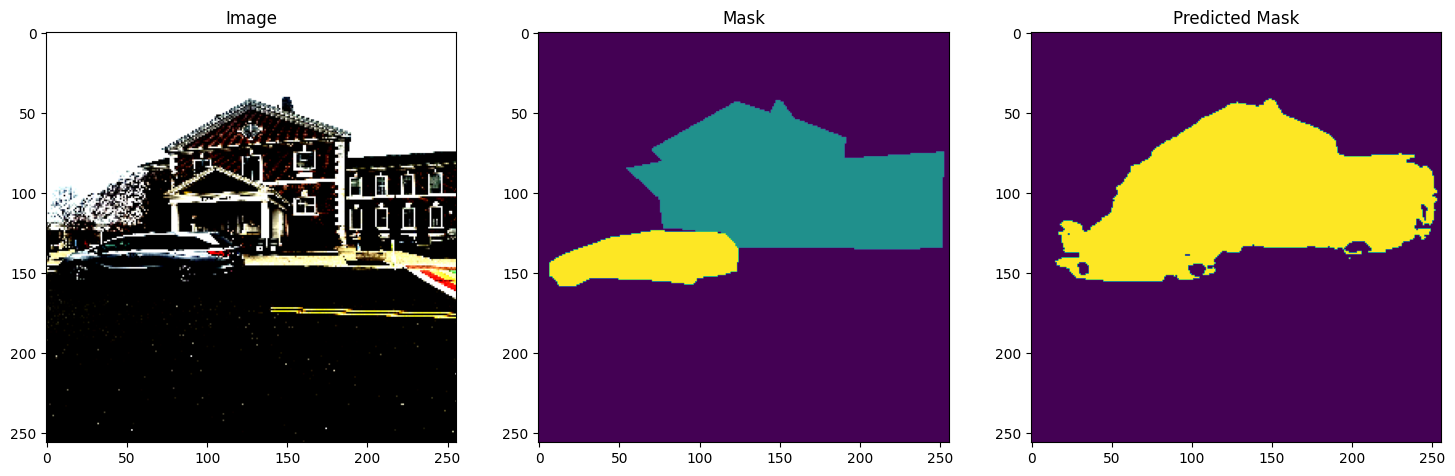

 75%|███████▌  | 3/4 [00:10<00:03,  3.49s/it]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


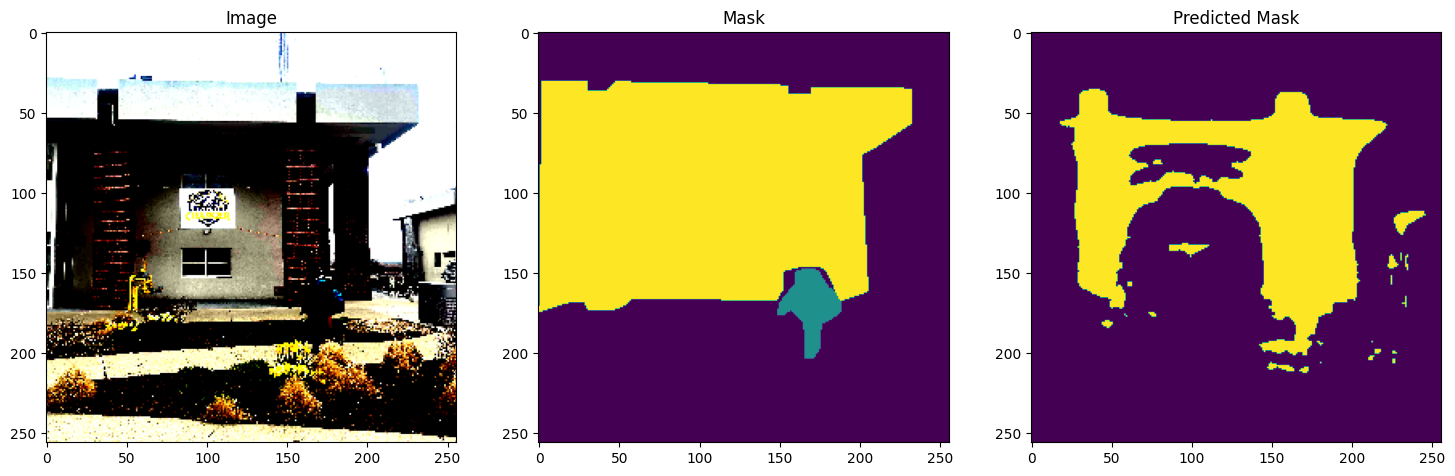

100%|██████████| 4/4 [00:11<00:00,  2.83s/it]


In [ ]:
# Disable gradient calculation to speed up inference
with torch.no_grad():
    # Loop over the data loader
    for batch_idx, (inputs, targets) in enumerate(tqdm(test_loader)):
        # Move the inputs and targets to the device
        inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)

        # Forward pass
        outputs = model(inputs)
        outputs = torch.argmax(softmax(outputs),axis=1)

        for i in range(inputs.shape[0]):

            image = inputs[i].to('cpu')
            mask = targets[i].to('cpu')
            pred_mask = outputs[i].to('cpu')

            fig , ax =  plt.subplots(1, 3, figsize=(18, 18))
            softmax = nn.Softmax(dim=1)

            image = image.permute(1, 2, 0).numpy()
            mask = mask.numpy()
            pred_mask = pred_mask.numpy()

            ax[0].imshow(image)
            ax[0].set_title("Image")

            ax[1].imshow(mask)
            ax[1].set_title("Mask")

            ax[2].imshow(pred_mask)
            ax[2].set_title("Predicted Mask")

            plt.show()

        # break

